In [12]:
import streamlit as st
from pandas_datareader.data import DataReader
import yfinance as yf
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from io import BytesIO

In [3]:
def plot_cum_returns(data, title):
    daily_cum_returns = 1 + data.dropna().pct_change()
    daily_cum_returns = daily_cum_returns.cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig

def plot_efficient_frontier_and_max_sharpe(mu, S):
    # Optimize portfolio for max Sharpe ratio and plot it out with efficient frontier curve
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(6,4))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.legend()
    return fig

In [9]:
st.set_page_config(page_title = "Bohmian's Stock Portfolio Optimizer", layout = "wide")
st.header("Bohmian's Stock Portfolio Optimizer")

col1, col2 = st.columns(2)
with col1:
    start_date = st.date_input("Start Date",datetime(2013, 1, 1))
with col2:
    end_date = st.date_input("End Date") # it defaults to current date

tickers_string = st.text_input('Enter all stock tickers to be included in portfolio separated by commas \
 WITHOUT spaces, e.g. "MA,FB,V,AMZN,JPM,BA"', '').upper()
tickers = tickers_string.split(',')

In [2]:
# except:
#     st.write('Enter correct stock tickers to be included in portfolio separated\
# 	by commas WITHOUT spaces, e.g. "MA,FB,V,AMZN,JPM,BA"and hit Enter.')

In [13]:
# Get Stock Prices using pandas_datareader Library
stocks_df = yf.download(tickers, start = start_date, end = end_date)['Adj Close']
# Plot Individual Stock Prices
fig_price = px.line(stocks_df, title='Price of Individual Stocks')

# Plot Individual Cumulative Returns
fig_cum_returns = plot_cum_returns(stocks_df, 'Cumulative Returns of Individual Stocks Starting with $100')

# Calculatge and Plot Correlation Matrix between Stocks
corr_df = stocks_df.corr().round(2)
fig_corr = px.imshow(corr_df, text_auto=True, title = 'Correlation between Stocks')

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- : No data found for this date range, symbol may be delisted


TypeError: corr() missing 1 required positional argument: 'other'

C:\Users\Sun Lee\AppData\Roaming\Python\Python39\site-packages\pypfopt\expected_returns.py:136: RuntimeWarning:

prices are not in a dataframe

C:\Users\Sun Lee\AppData\Roaming\Python\Python39\site-packages\pypfopt\risk_models.py:165: RuntimeWarning:

data is not in a dataframe

C:\Users\Sun Lee\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:495: RuntimeWarning:

Mean of empty slice.

C:\Users\Sun Lee\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:181: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:9679: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Sun Lee\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\Sun Lee\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning:

invalid value encountered in multiply



OptimizationError: Please check your objectives/constraints or use a different solver.

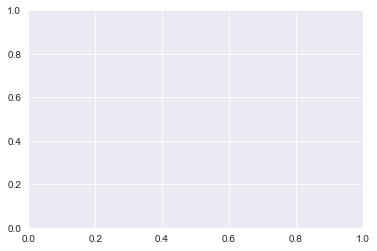

In [16]:
# Calculate expected returns and sample covariance matrix for portfolio optimization later
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)

# Plot efficient frontier curve
fig = plot_efficient_frontier_and_max_sharpe(mu, S)
fig_efficient_frontier = BytesIO()
fig.savefig(fig_efficient_frontier, format="png")

# Get optimized weights
ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=0.02)
weights = ef.clean_weights()
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()
weights_df = pd.DataFrame.from_dict(weights, orient = 'index')
weights_df.columns = ['weights']

In [17]:
# Calculate returns of portfolio with optimized weights
stocks_df['Optimized Portfolio'] = 0
for ticker, weight in weights.items():
    stocks_df['Optimized Portfolio'] += stocks_df[ticker]*weight

# Plot Cumulative Returns of Optimized Portfolio
fig_cum_returns_optimized = plot_cum_returns(stocks_df['Optimized Portfolio'], 'Cumulative Returns of Optimized Portfolio Starting with $100')

NameError: name 'weights' is not defined

In [18]:
# Display everything on Streamlit
st.subheader("Your Portfolio Consists of {} Stocks".format(tickers_string))
st.plotly_chart(fig_cum_returns_optimized)

st.subheader("Optimized Max Sharpe Portfolio Weights")
st.dataframe(weights_df)

st.subheader("Optimized Max Sharpe Portfolio Performance")
st.image(fig_efficient_frontier)

st.subheader('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
st.subheader('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
st.subheader('Sharpe Ratio: {}'.format(sharpe_ratio.round(2)))

st.plotly_chart(fig_corr) # fig_corr is not a plotly chart
st.plotly_chart(fig_price)
st.plotly_chart(fig_cum_returns)

NameError: name 'fig_cum_returns_optimized' is not defined